In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from acquire import acquire_zillow, quick_sum, object_values, cont_hist
from prepare import column_nulls, nulls_by_row, handle_missing_values, split_data, delete_outliers, create_features, Min_Max_Scaler 

## Clustering Rough Draft Notebook

### Acquire Zillow

In [2]:
zillow_df = acquire_zillow() ## <-- calling our function documented in acquire_zillow.py

zillow_df.head() ## <-- Looking at out dataframe

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,logerror,...,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,0,0.025595,...,None,NaN,6.059063e+13,None,None,None,None,Single Family Residential,None,None
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1,0.055619,...,None,NaN,6.111001e+13,None,None,None,None,Single Family Residential,None,None
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,2,0.005383,...,None,NaN,6.059022e+13,None,None,None,None,Single Family Residential,None,None
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,3,-0.103410,...,None,NaN,6.037300e+13,None,None,None,Central,Single Family Residential,None,None
6,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12095076,6,-0.001011,...,None,NaN,6.037461e+13,Central,None,None,Central,Single Family Residential,None,None


In [3]:
quick_sum(zillow_df)  ## <-- function to give shape, datatypes, and numerical statistics

Dataframe Shape (rows, columns):
(52320, 68)
-----------------------------------------------

Datatypes of Columns:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 0 to 77579
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52320 non-null  float64
 3   heatingorsystemtypeid         33850 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52320 non-null  int64  
 8   id                            52320 non-null  int64  
 9   logerror                      52320 non-null  float64
 10  transactiondate               52320 non-null  object 
 11  bas

In [4]:
## dropping columns with 0 non null values right away based on the .info printout
null_cols = ['buildingclassdesc', 'finishedsquarefeet13', 
             'finishedsquarefeet15', 'buildingclasstypeid']

zillow_df = zillow_df.drop(columns = null_cols) ## <-- dropping those pesky columns

zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 0 to 77579
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52320 non-null  float64
 3   heatingorsystemtypeid         33850 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   airconditioningtypeid         13615 non-null  float64
 6   parcelid                      52320 non-null  int64  
 7   id                            52320 non-null  int64  
 8   logerror                      52320 non-null  float64
 9   transactiondate               52320 non-null  object 
 10  basementsqft                  47 non-null     float64
 11  bathroomcnt                   52320 non-null  float64
 12  bedroomcnt                    52320 non-null  float64
 13  b

In [5]:
object_values(zillow_df)  ## <-- function that lists object columns's value counts

transactiondate
2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-06-03      1
2017-09-20      1
2017-04-08      1
2017-08-12      1
2017-09-10      1
Name: transactiondate, Length: 258, dtype: int64
-----------------------------------------------

propertycountylandusecode
0100    26714
122     13045
0101     6399
1111     3353
1        1066
1110     1024
0104      367
010G       93
0103       91
0108       57
010M       52
0109       18
1112        8
0113        6
0110        6
0141        4
0102        3
0105        3
010V        2
0130        2
0111        2
0114        1
0133        1
0131        1
010L        1
0115        1
Name: propertycountylandusecode, dtype: int64
-----------------------------------------------

propertyzoningdesc
LAR1       6480
LARS       1380
LBR1N      1109
SCUR2       712
LARE11      611
           ... 
LRMPD*        1
LRA12*        1
EMC2*         1
LRRR2.5       1
LHRA1         1
Name: pr

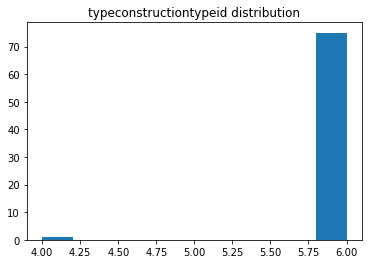

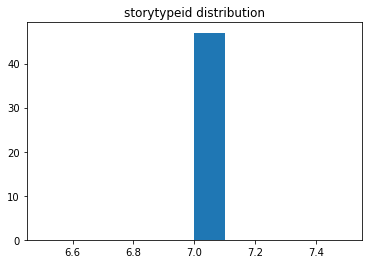

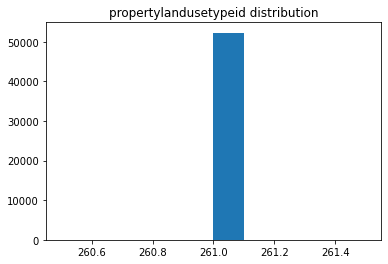

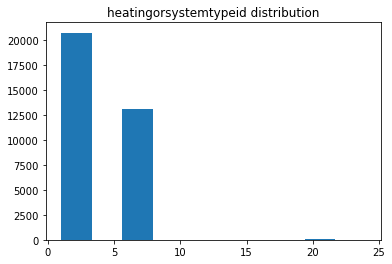

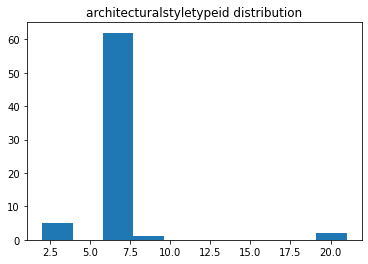

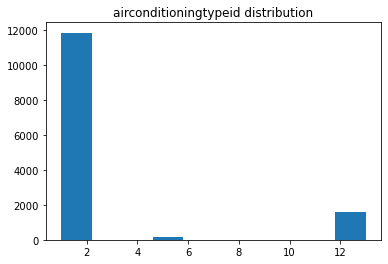

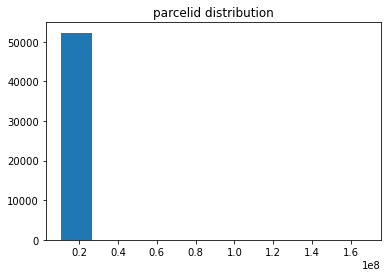

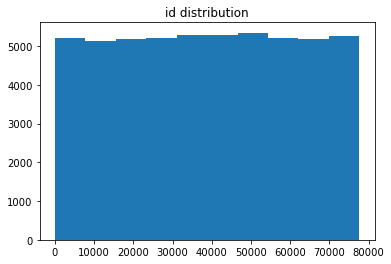

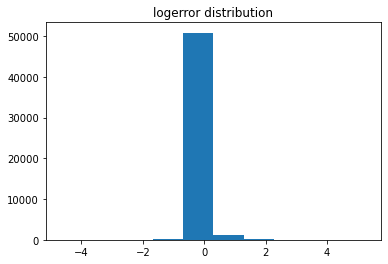

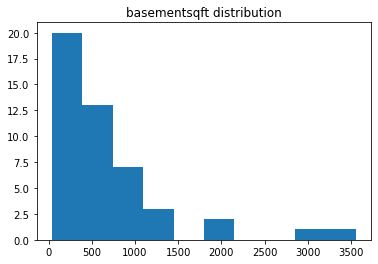

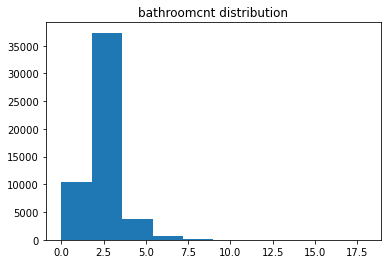

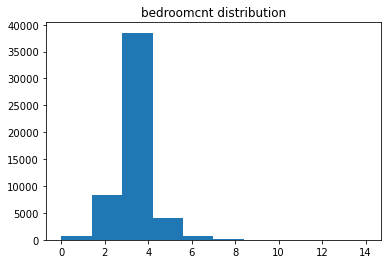

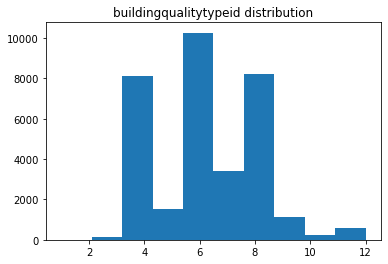

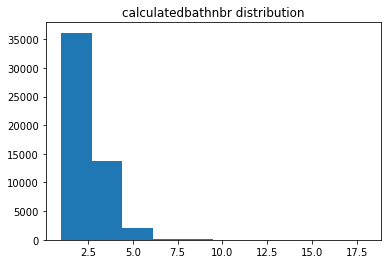

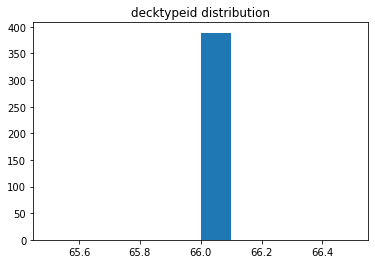

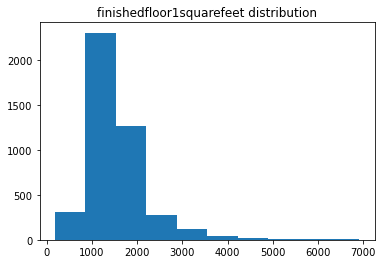

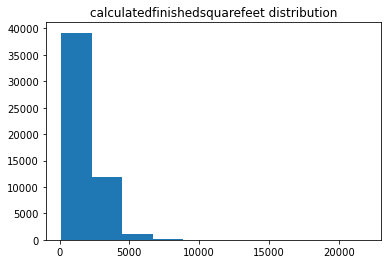

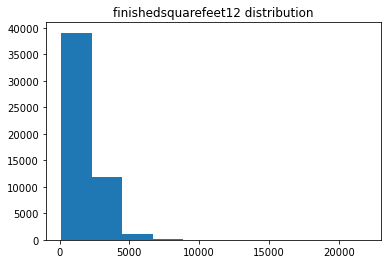

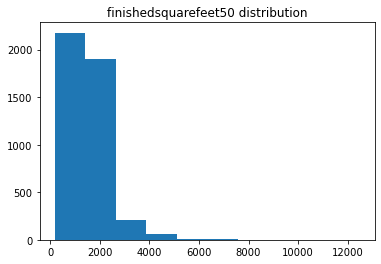

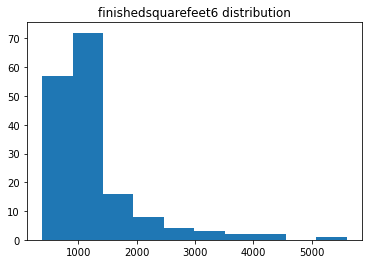

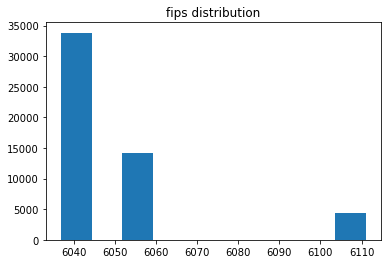

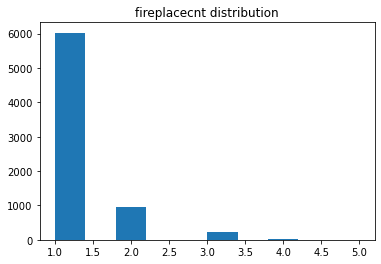

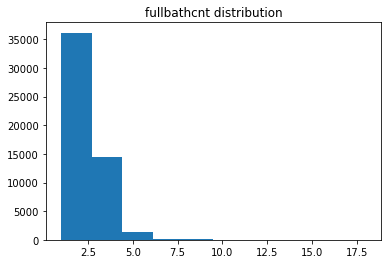

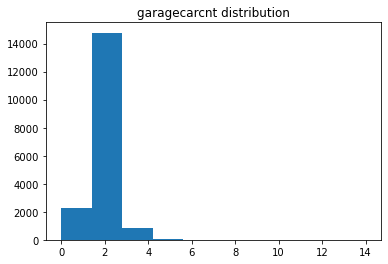

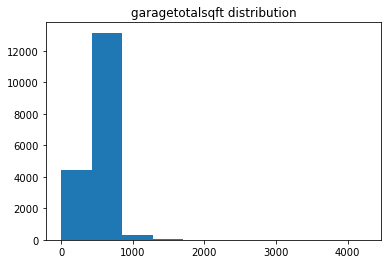

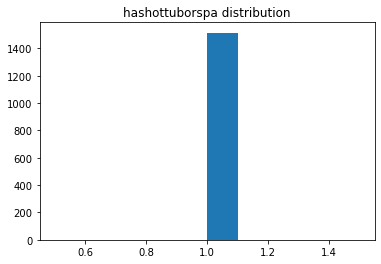

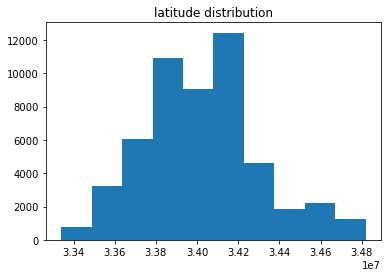

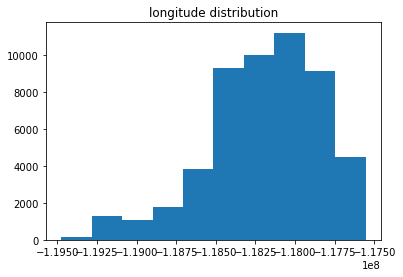

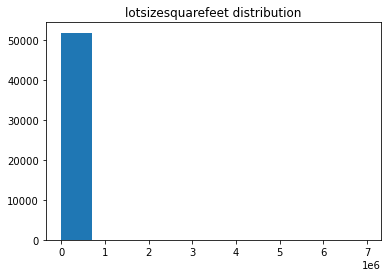

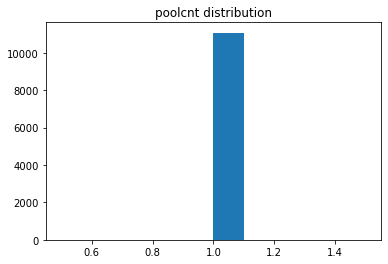

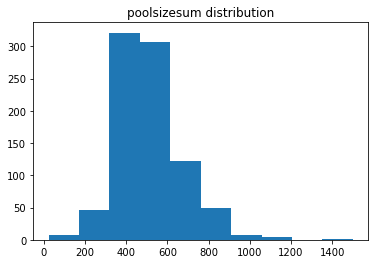

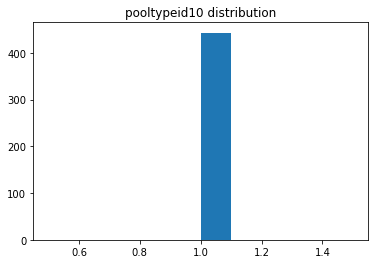

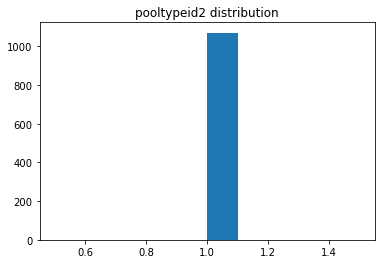

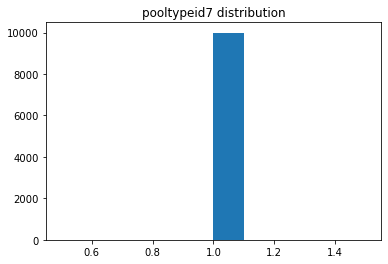

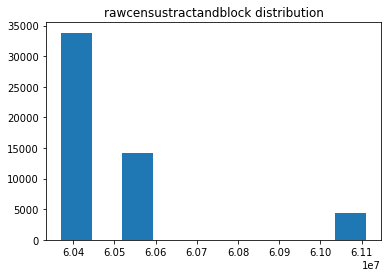

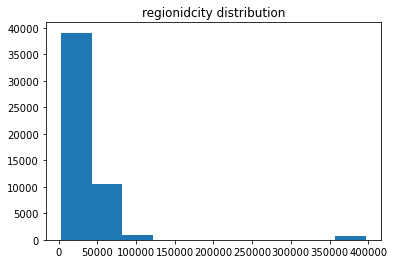

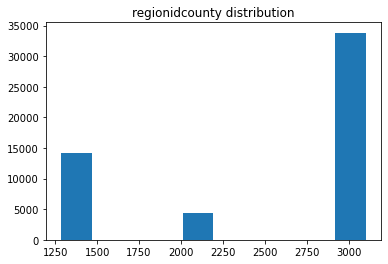

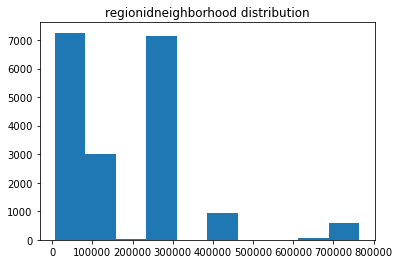

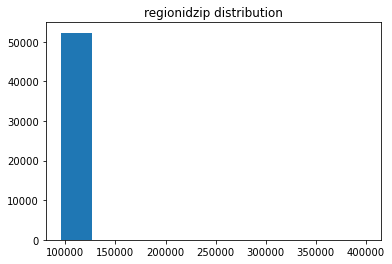

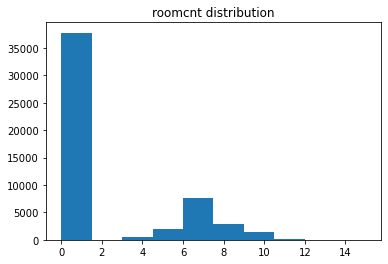

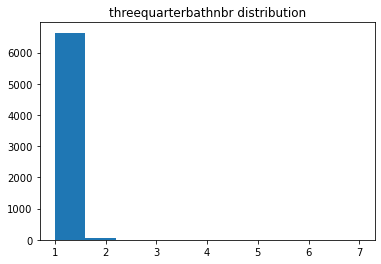

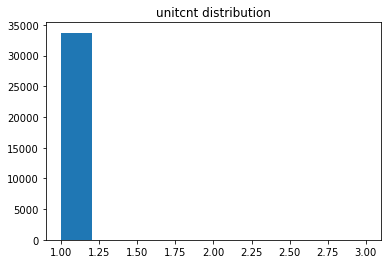

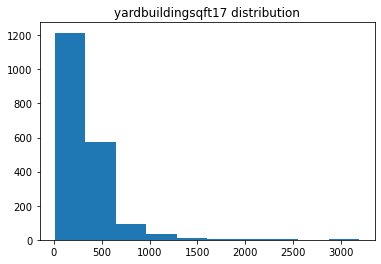

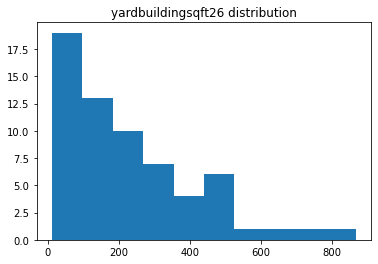

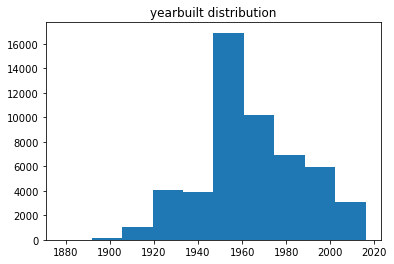

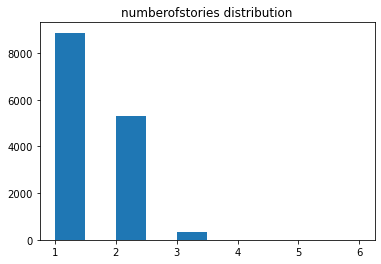

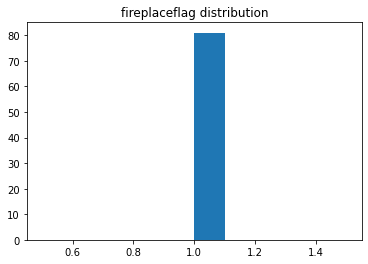

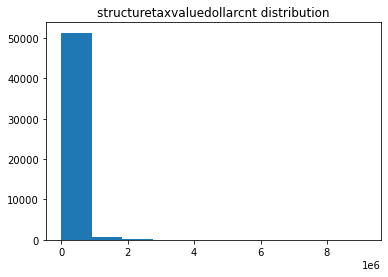

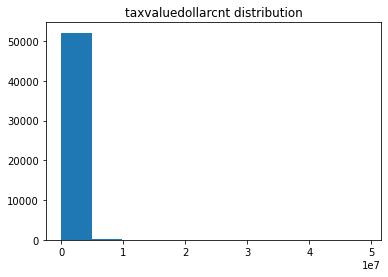

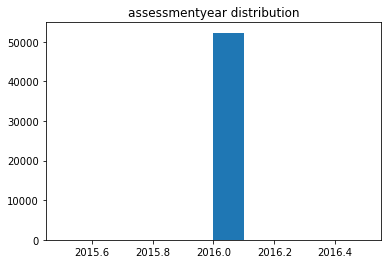

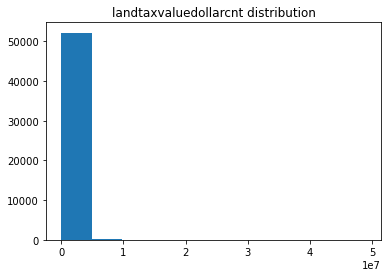

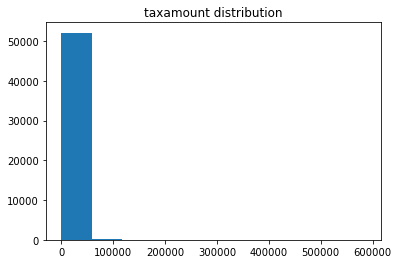

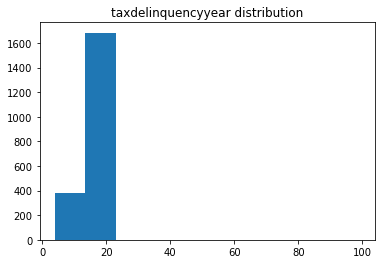

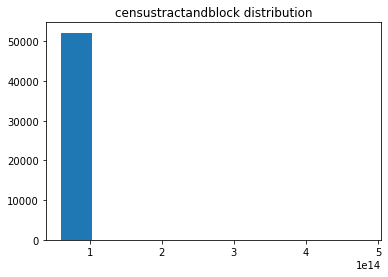

In [6]:
cont_hist(zillow_df)  ## <-- function that looks at the distributions of continuous variables

## Prepare Zillow

In [7]:
column_nulls(zillow_df) ## <-- function that looks null values by column

,num_rows_missing,pct_rows_missing
typeconstructiontypeid,52244,0.998547
storytypeid,52273,0.999102
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,18470,0.353020
architecturalstyletypeid,52250,0.998662
...,...,...
architecturalstyledesc,52250,0.998662
heatingorsystemdesc,18470,0.353020
propertylandusedesc,0,0.000000
storydesc,52273,0.999102


In [8]:
nulls_by_row(zillow_df) ## <-- function that looks at the nulls by row

,num_cols_missing,pct_cols_missing,num_rows
0,19,29.6875,2
1,20,31.25,12
2,21,32.8125,11
3,22,34.375,30
4,23,35.9375,177
5,24,37.5,390
6,25,39.0625,2527
7,26,40.625,2199
8,27,42.1875,5989
9,28,43.75,8885


In [9]:
handle_missing_values(zillow_df) ## <-- function that handles missing values
## based on .5 threshhold determined from the functions above

,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,propertylandusedesc
0,261.0,NaN,14297519,0,0.025595,2017-01-01,3.5,4.0,NaN,3.5,...,NaN,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,None,Single Family Residential
1,261.0,NaN,17052889,1,0.055619,2017-01-01,1.0,2.0,NaN,1.0,...,NaN,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,None,Single Family Residential
2,261.0,NaN,14186244,2,0.005383,2017-01-01,2.0,3.0,NaN,2.0,...,NaN,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,None,Single Family Residential
3,261.0,2.0,12177905,3,-0.103410,2017-01-01,3.0,4.0,8.0,3.0,...,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,Central,Single Family Residential
6,261.0,2.0,12095076,6,-0.001011,2017-01-01,3.0,4.0,9.0,3.0,...,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,261.0,2.0,11000655,77609,0.020615,2017-09-20,2.0,2.0,6.0,2.0,...,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,Central,Single Family Residential
77576,261.0,NaN,17239384,77610,0.013209,2017-09-21,2.0,4.0,NaN,2.0,...,NaN,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,None,Single Family Residential
77577,261.0,2.0,12773139,77611,0.037129,2017-09-21,1.0,3.0,4.0,1.0,...,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,Central,Single Family Residential
77578,261.0,2.0,12826780,77612,0.007204,2017-09-25,2.0,3.0,6.0,2.0,...,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,Central,Single Family Residential


In [10]:
zillow_df.isnull().sum()[zillow_df.isnull().sum()>0] # look at cols with nulls

heatingorsystemtypeid           18470
buildingqualitytypeid           18665
calculatedbathnbr                 135
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
fullbathcnt                       135
lotsizesquarefeet                 366
propertyzoningdesc              18558
regionidcity                     1036
regionidzip                        26
unitcnt                         18558
yearbuilt                         114
structuretaxvaluedollarcnt         82
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               1
taxamount                           4
censustractandblock               121
heatingorsystemdesc             18470
dtype: int64

In [11]:
# dropping the columns with 18K missing values too much to fill/impute/drop rows
zillow_df = zillow_df.drop(columns = ['heatingorsystemtypeid', 'buildingqualitytypeid',
                                      'propertyzoningdesc', 'unitcnt', 
                                      'heatingorsystemdesc'])

zillow_df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
id                                 0
logerror                           0
transactiondate                    0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                135
calculatedfinishedsquarefeet      81
finishedsquarefeet12             246
fips                               0
fullbathcnt                      135
latitude                           0
longitude                          0
lotsizesquarefeet                366
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1036
regionidcounty                     0
regionidzip                       26
roomcnt                            0
yearbuilt                        114
structuretaxvaluedollarcnt        82
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
c

In [12]:
zillow_df = zillow_df.dropna()  ## <-- drop the nulls for the first run through
zillow_df.shape 

(50560, 29)

In [13]:
zillow_df.isnull().sum() ## <-- making sure the nulls are gone

propertylandusetypeid           0
parcelid                        0
id                              0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
dtype: int64

In [14]:
zillow_df = create_features(zillow_df) ## <-- function to create more features

In [15]:
train, validate, test = split_data(zillow_df) ## <-- function to split data into train validate and test

In [16]:
train.shape, validate.shape, test.shape

((28313, 36), (12135, 36), (10112, 36))

In [17]:
train.head()

,propertylandusetypeid,parcelid,id,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxamount,censustractandblock,propertylandusedesc,age,age_bin,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio
38208,261.0,10966493,38223,0.050380,2017-05-19,2.0,4.0,2.0,1170.0,1170.0,...,744.92,6.037107e+13,Single Family Residential,63.0,0.466,1.272128,0.138843,0.1,0.2,0.500000
71943,261.0,10773573,71973,0.031721,2017-08-30,1.0,3.0,1.0,980.0,980.0,...,4827.35,6.037135e+13,Single Family Residential,66.0,0.466,1.203759,0.162534,0.2,0.1,0.333333
26640,261.0,12396711,26653,-0.024260,2017-04-14,3.0,5.0,3.0,2375.0,2375.0,...,4560.80,6.037502e+13,Single Family Residential,67.0,0.466,1.294398,0.120202,0.1,0.5,0.600000
6803,261.0,12840203,6809,0.153838,2017-01-31,4.0,5.0,4.0,3255.0,3255.0,...,5838.96,6.037409e+13,Single Family Residential,25.0,0.200,1.251334,0.245868,0.2,0.7,0.800000
75193,261.0,12864189,75227,0.000536,2017-09-08,2.0,3.0,2.0,1768.0,1768.0,...,4018.67,6.037402e+13,Single Family Residential,53.0,0.400,1.281451,0.263935,0.3,0.4,0.666667


In [18]:
validate.head()

,propertylandusetypeid,parcelid,id,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxamount,censustractandblock,propertylandusedesc,age,age_bin,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio
59891,261.0,11415211,59915,0.032461,2017-07-24,1.0,2.0,1.0,781.0,781.0,...,3007.04,6.037602e+13,Single Family Residential,69.0,0.466,1.580282,0.135285,0.1,0.0,0.500000
64482,261.0,10922040,64508,-0.054856,2017-08-08,1.0,2.0,1.0,964.0,964.0,...,828.86,6.037102e+13,Single Family Residential,81.0,0.600,1.362495,0.313636,0.3,0.1,0.500000
29816,261.0,12854930,29830,-0.040826,2017-04-26,2.0,3.0,2.0,1300.0,1300.0,...,3669.28,6.037403e+13,Single Family Residential,54.0,0.400,1.225172,0.237741,0.2,0.3,0.666667
7155,261.0,14300843,7161,0.047229,2017-02-01,1.0,2.0,1.0,976.0,976.0,...,8633.86,6.059053e+13,Single Family Residential,46.0,0.333,1.024883,0.118067,0.1,0.1,0.500000
5940,261.0,11321438,5946,-0.006352,2017-01-27,3.0,4.0,3.0,3437.0,3437.0,...,5913.77,6.037901e+13,Single Family Residential,11.0,0.133,1.647290,0.257002,0.3,0.7,0.750000


In [19]:
test.head()

,propertylandusetypeid,parcelid,id,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxamount,censustractandblock,propertylandusedesc,age,age_bin,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio
28464,261.0,12915644,28478,-0.019285,2017-04-21,2.0,3.0,2.0,1198.0,1198.0,...,1273.42,6.037406e+13,Single Family Residential,59.0,0.400,1.561176,0.153007,0.2,0.2,0.666667
10981,261.0,14082257,10990,-0.011435,2017-02-21,2.5,3.0,2.5,1540.0,1540.0,...,6085.10,6.059099e+13,Single Family Residential,27.0,0.200,1.148132,0.072314,0.0,0.4,0.833333
42750,261.0,12401020,42769,-0.071271,2017-06-02,3.0,3.0,3.0,2443.0,2443.0,...,5708.86,6.037551e+13,Single Family Residential,62.0,0.466,1.247290,0.225666,0.2,0.5,1.000000
76900,261.0,14015161,76934,-0.000844,2017-09-15,2.0,3.0,2.0,1108.0,1108.0,...,4223.08,6.059110e+13,Single Family Residential,61.0,0.466,1.176414,0.152893,0.2,0.2,0.666667
17647,261.0,12499543,17657,-0.041809,2017-03-16,2.0,4.0,2.0,1432.0,1432.0,...,4755.82,6.037572e+13,Single Family Residential,73.0,0.533,1.224704,0.123691,0.1,0.3,0.500000


### Explore 

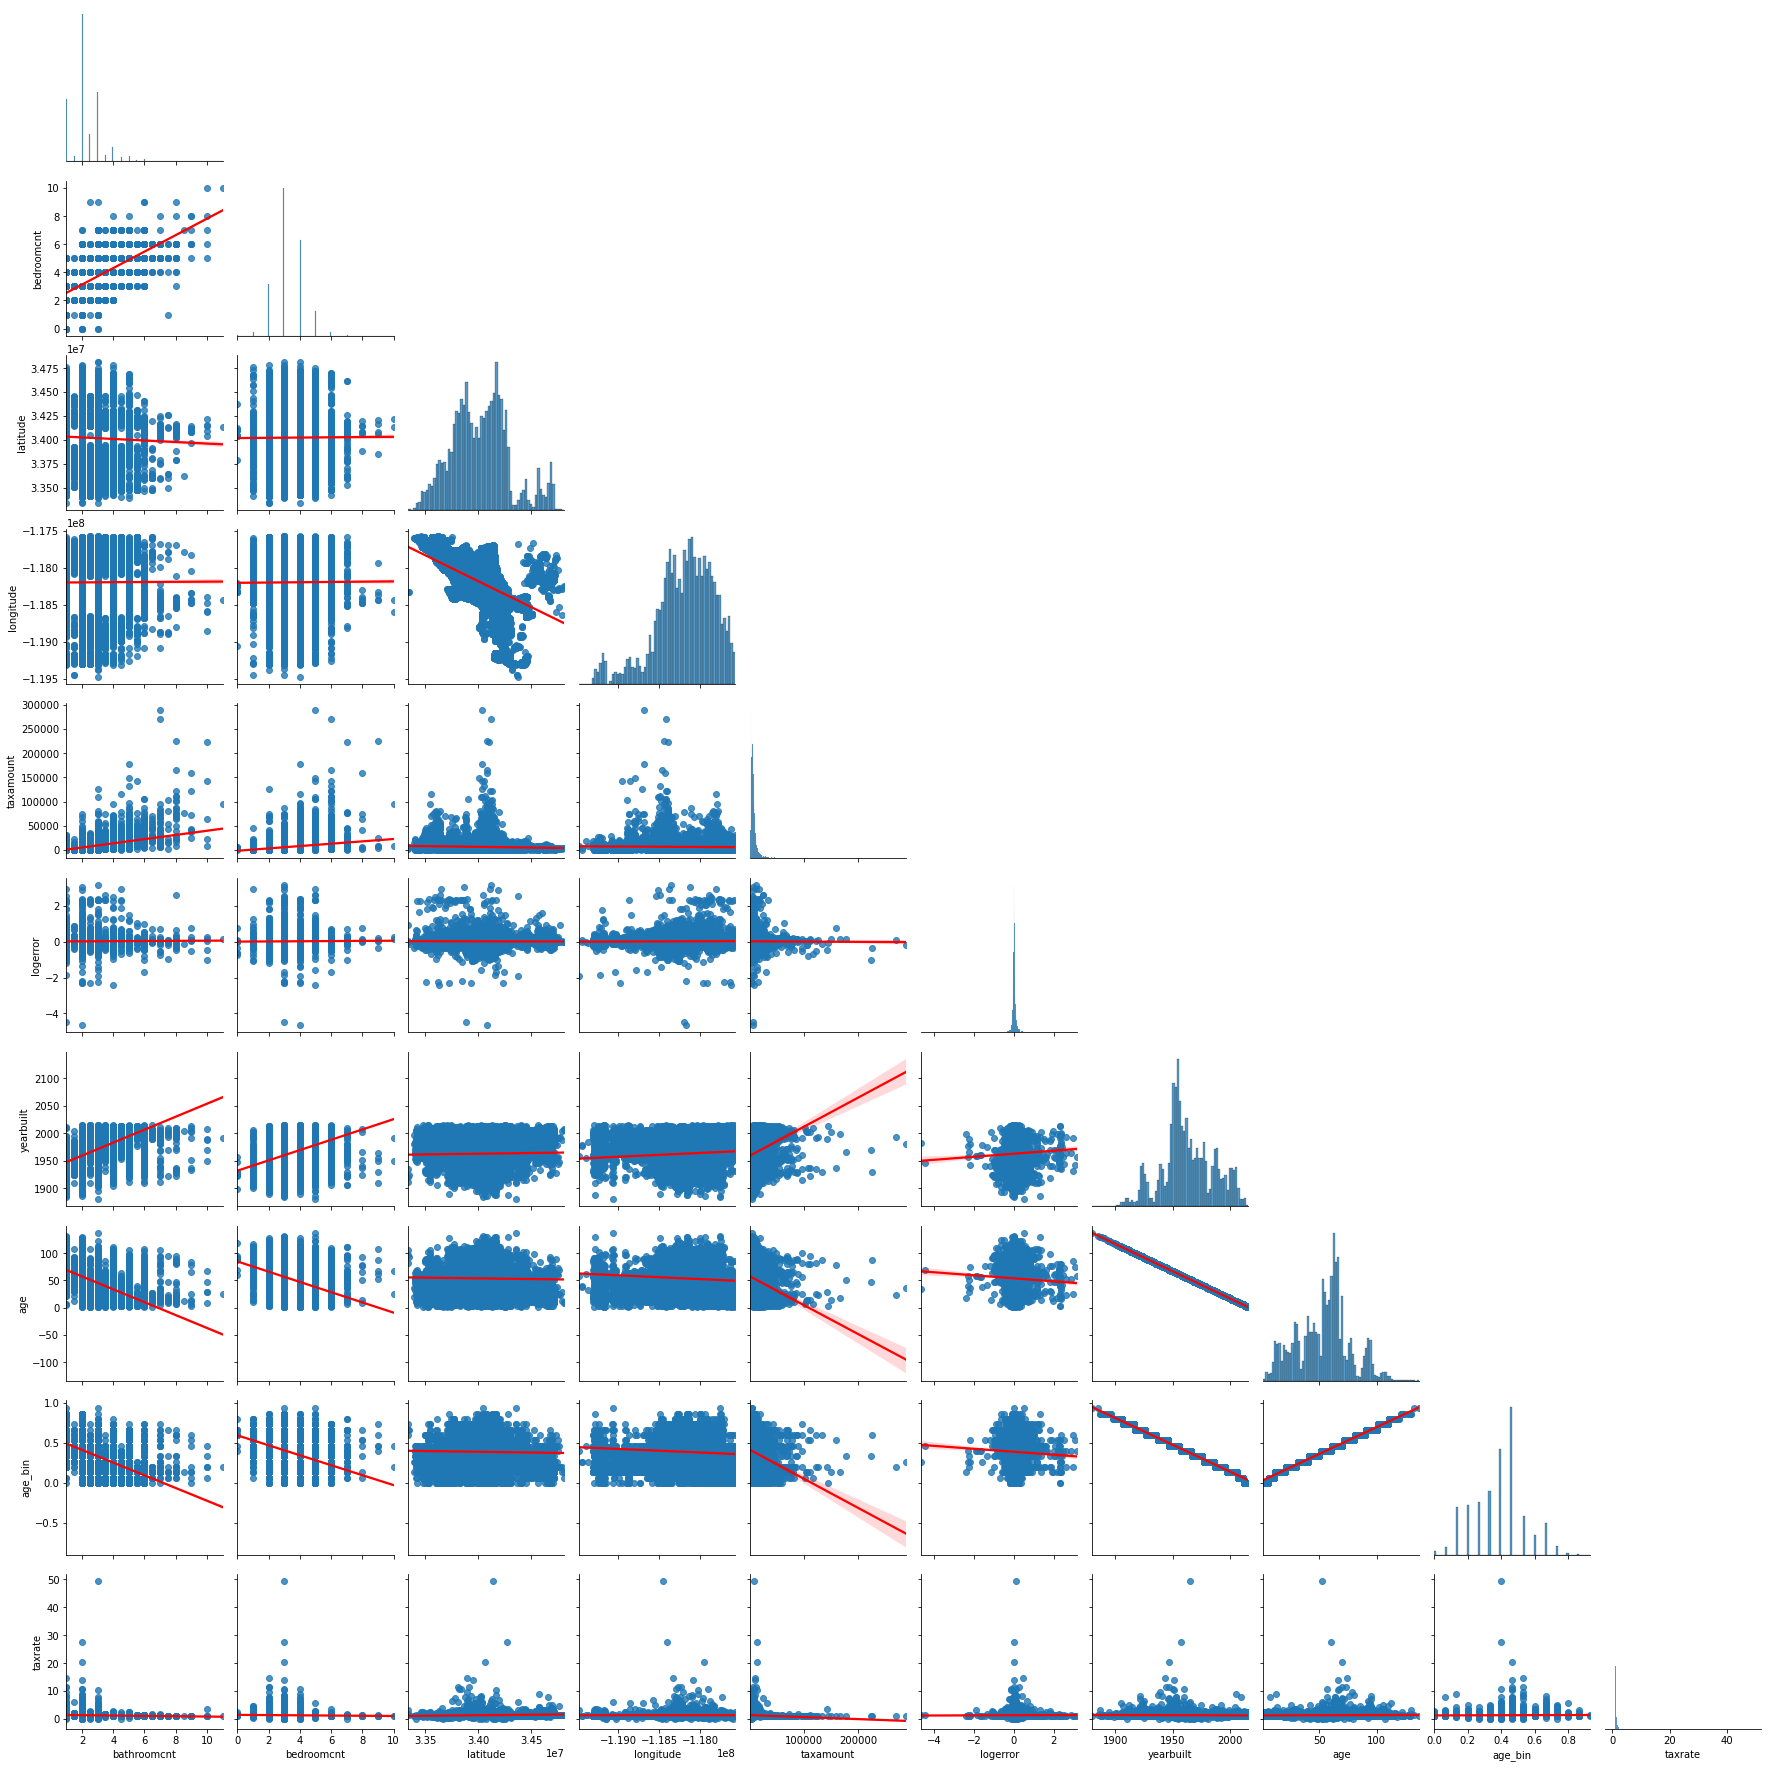

In [20]:
## making a cornered pairplot with red regression line with features I have decided
## will be of most use and the target variable logerror

cols2 = ['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 
        'taxamount', 'logerror','yearbuilt', 'age', 'age_bin', 'taxrate']

cols = ['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 
        'taxamount', 'logerror','yearbuilt', 'age', 'age_bin', 'taxrate',
        'acres', 'acres_bin', 'sqft_bin' , 'bath_bed_ratio']

sns.pairplot(train[cols2], corner = True, kind = 'reg', 
             plot_kws={'line_kws':{'color':'red'}})

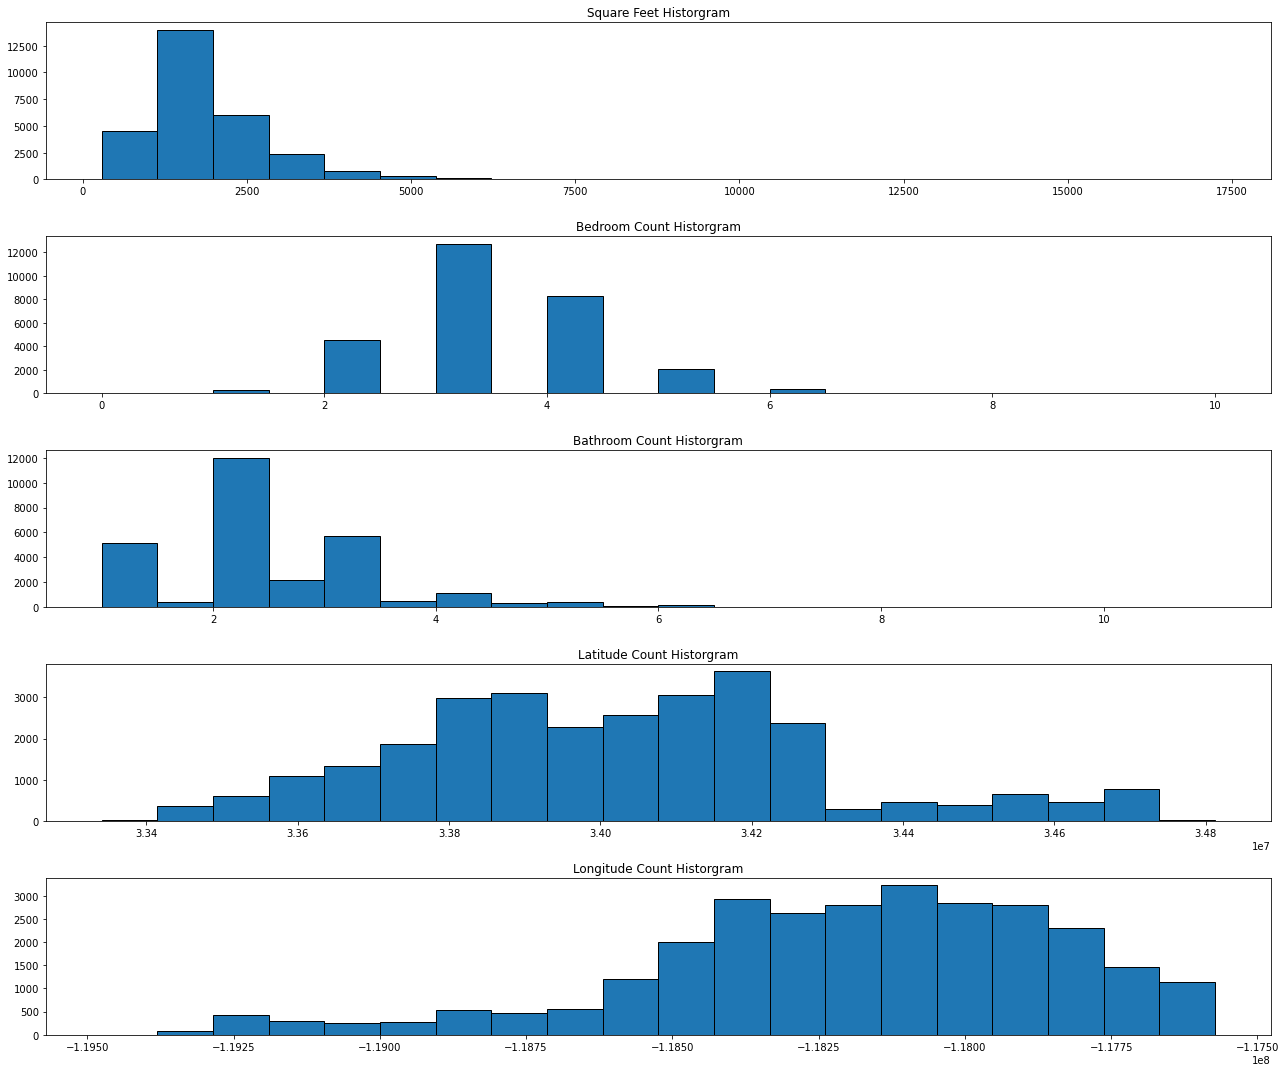

In [21]:
plt.figure(figsize = (18,15))
plt.subplot(5,1,1, title ='Square Feet Historgram')
plt.hist(data=train, x='calculatedfinishedsquarefeet', bins = 20, ec = 'black')

plt.subplot(5,1,2, title ='Bedroom Count Historgram')
plt.hist(data=train, x='bedroomcnt', bins = 20, ec = 'black')

plt.subplot(5,1,3, title ='Bathroom Count Historgram')
plt.hist(data=train, x='bathroomcnt', bins = 20, ec = 'black')

plt.subplot(5,1,4, title ='Latitude Count Historgram')
plt.hist(data=train, x='latitude', bins = 20, ec = 'black')

plt.subplot(5,1,5, title ='Longitude Count Historgram', )
plt.hist(data=train, x='longitude', bins = 20, ec = 'black')

plt.tight_layout()
plt.show()

## Relationships

Relationship between Latitude and Logerror(?)


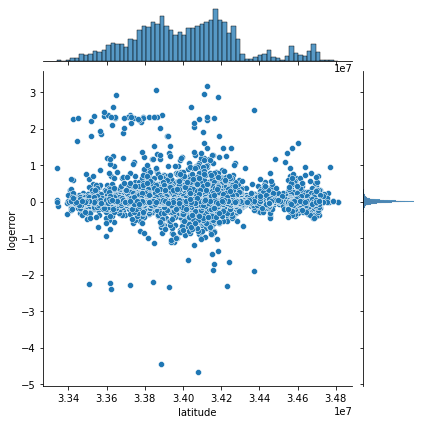

In [22]:
print('Relationship between Latitude and Logerror(?)')
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Latitude')
plt.ylabel('Log Error')
plt.show()

Relationship between Longitude and Logerror(?)


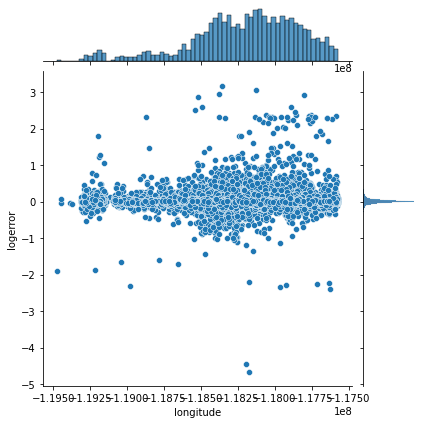

In [23]:
print('Relationship between Longitude and Logerror(?)')
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Log Error')
plt.show()

Relationship between Square Feet and Logerror(?)


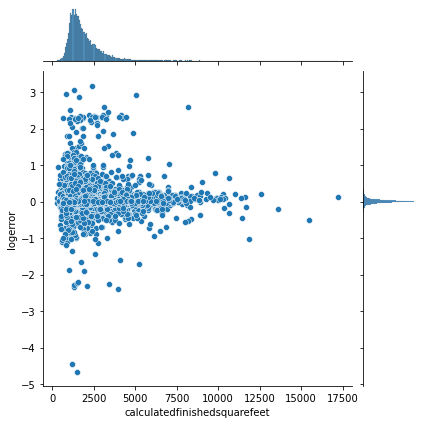

In [24]:
print('Relationship between Square Feet and Logerror(?)')
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.xlabel('Square Feet')
plt.ylabel('Log Error')
plt.show()

Relationship between # of Bedrooms and Logerror(?)


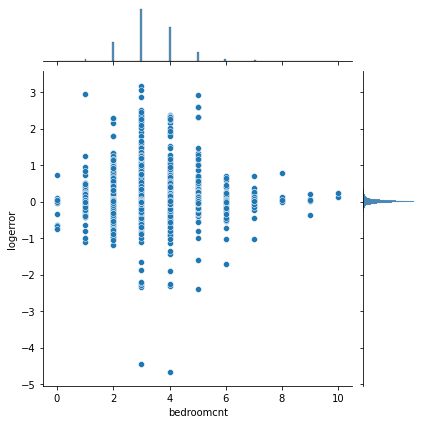

In [25]:
print('Relationship between # of Bedrooms and Logerror(?)')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.show()

Relationship between # of Bathrooms and Logerror(?)


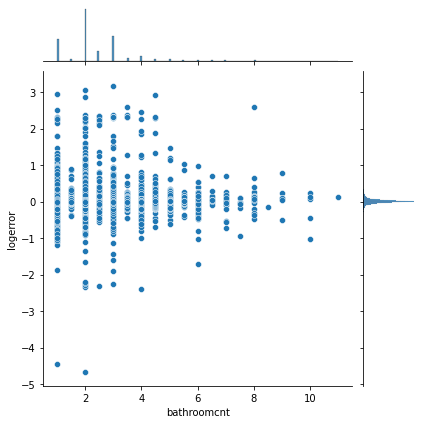

In [26]:
print('Relationship between # of Bathrooms and Logerror(?)')
sns.jointplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.show()

Relationship between Tax Amount and Logerror(?)


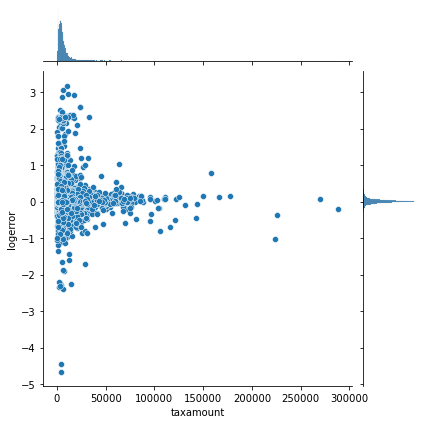

In [27]:
print('Relationship between Tax Amount and Logerror(?)')
sns.jointplot(x='taxamount', y='logerror', data=train)
plt.xlabel('Tax Amount')
plt.ylabel('Log Error')
plt.show()

Relationship between the Year Built and Logerror(?)


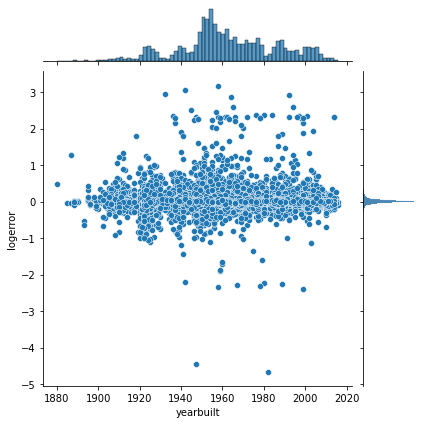

In [28]:
print('Relationship between the Year Built and Logerror(?)')
sns.jointplot(x='yearbuilt', y='logerror', data=train)
plt.xlabel('Year Built')
plt.ylabel('Log Error')
plt.show()

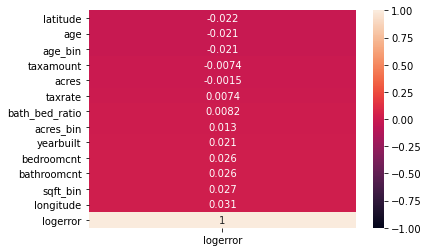

In [29]:
heatmap_cols = train[cols] ## <-- making a sub dataframe to only look at the columns
## I want to see correlations for in a heatmap

sns.heatmap(heatmap_cols.corr()[['logerror']].sort_values(by='logerror'), annot = True,
           vmin = -1, vmax = 1)   ## <-- making my heatmap
plt.show()

## Making Clusters and Exploring

In [30]:
## First we are going to make train, validate, test the columns we want 
## for easier exploration

train = train[cols]
validate = validate[cols]
test = test[cols]

train.shape, validate.shape, test.shape ## <-- checking to see that we have 7 columns now

((28313, 14), (12135, 14), (10112, 14))

In [31]:
train.head()  ## <-- looking at out train dataframe 

,bathroomcnt,bedroomcnt,latitude,longitude,taxamount,logerror,yearbuilt,age,age_bin,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio
38208,2.0,4.0,34301175.0,-118458283.0,744.92,0.050380,1954.0,63.0,0.466,1.272128,0.138843,0.1,0.2,0.500000
71943,1.0,3.0,34205841.0,-118569719.0,4827.35,0.031721,1951.0,66.0,0.466,1.203759,0.162534,0.2,0.1,0.333333
26640,3.0,5.0,33973025.0,-118091262.0,4560.80,-0.024260,1950.0,67.0,0.466,1.294398,0.120202,0.1,0.5,0.600000
6803,4.0,5.0,33977454.0,-117903393.0,5838.96,0.153838,1992.0,25.0,0.200,1.251334,0.245868,0.2,0.7,0.800000
75193,2.0,3.0,34112387.0,-117735062.0,4018.67,0.000536,1964.0,53.0,0.400,1.281451,0.263935,0.3,0.4,0.666667


In [32]:
## splitting into x and y's

X_train, y_train = train.drop(columns = 'logerror'), train['logerror']
X_validate, y_validate = train.drop(columns = 'logerror'), validate['logerror']
X_test, y_test = train.drop(columns = 'logerror'), test['logerror']

In [34]:
X_train.head()

,bathroomcnt,bedroomcnt,latitude,longitude,taxamount,yearbuilt,age,age_bin,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio
38208,2.0,4.0,34301175.0,-118458283.0,744.92,1954.0,63.0,0.466,1.272128,0.138843,0.1,0.2,0.500000
71943,1.0,3.0,34205841.0,-118569719.0,4827.35,1951.0,66.0,0.466,1.203759,0.162534,0.2,0.1,0.333333
26640,3.0,5.0,33973025.0,-118091262.0,4560.80,1950.0,67.0,0.466,1.294398,0.120202,0.1,0.5,0.600000
6803,4.0,5.0,33977454.0,-117903393.0,5838.96,1992.0,25.0,0.200,1.251334,0.245868,0.2,0.7,0.800000
75193,2.0,3.0,34112387.0,-117735062.0,4018.67,1964.0,53.0,0.400,1.281451,0.263935,0.3,0.4,0.666667


In [35]:
y_train.head()

38208    0.050380
71943    0.031721
26640   -0.024260
6803     0.153838
75193    0.000536
Name: logerror, dtype: float64